In [1]:
from _01_mnist_example import x_train, x_test, y_train, y_test
from _01_mnist_example import y_train_5, y_test_5
from _01_mnist_example import sgd_clf

# 분류기의 평가
분류기의 평가는 회귀 모델의 평가보다 훨씬 어려움  
사용할 수 있는 성능지표가 매우 많음  
> **교차 검증  
오차 행렬  
정밀도와 재현율  
ROC 곡선**  


## 1. 교차 검층

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_idx, test_idx in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train.loc[train_idx]
    y_train_folds = y_train_5.loc[train_idx]
    x_test_folds = x_train.loc[test_idx]
    y_test_folds = y_train_5.loc[test_idx]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


**clone** 클래스는 입력된 에스티메이터와 같은 파라미터를 가졌지만 어떤 데이터에도 fit되지 않은 에스티메이터를 복사함  


In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

위와 동일한 역할을 하는 코드

In [22]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)

In [24]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

정확도가 90이 넘어서 좋아보일 수 있음  
**하지만** 전체 이미지의 10%정도만 5이기 때문에 무조건 5가 아니다라고 해도 정확도가 90임  
이는 정확도를 분류기의 성능 지표로 선호하지 않는 이유를 보여줌  
특히 **불균형한 데이터셋**을 다룰 때 더욱 그럼

## 2. 오차 행렬
기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것  
오차 행렬을 만들려면 실제 타깃과 비교할 수 있는 **예측값**을 만들어야 함  
이때 테스트셋은 이요하면 안됨. 테스트셋은 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용되어야 함  
그래서 **cross_val_predict**를 사용함

In [25]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

cross_val_predict는 cross_val_score처럼 k-겹 교차검증을 수행하지만  
평가점수를 반환하는 것이 아니라 예측값을 반환함

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

**confusion_matrix**를 이용해 오차행렬을 구함  
오차 행렬의 행은 **실제 클래스**를 의미함  
오차 행렬의 열은 **예측 클래스**를 의미함  
> 오차 행렬의 (1, 1)성분은 **True negative**  
오차 행렬의 (1, 2)성분은 **False positive**  
오차 행렬의 (2, 1)성분은 **False negative**  
오차 행렬의 (2, 2)성분은 **True positive**  를 의미함

In [28]:
y_train_perfect_pred = y_train_5
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

예를 들어 완벽한 분류기라면 위처럼 대각선 성분만 남음

## 3. 정밀도와 재현율
오차행렬에서 더 요약된 지표를 추출한 것  
>**정밀도**  
TP / (TP + FP)  
분류기가 양성이라고 예측한 것 충에서 진짜 양성의 비율  
**예측한 것 중 정답의 비율은?**
  
>**재현율**  
TP / (TP + FN)  
진짜 양성들 중에서 분류기가 양성이라고 예측한 비율  
**찾아야 할 것들 중에서 찾은 비율은?**

In [31]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [32]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [33]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율의 조화평균인 **f1_score**도 많이 사용함  
정밀도와 재현율이 비슷할 수록 f1_score가 올라감  
>하지만 상황에 따라 정밀도와 재현율의 중요도는 달라질 수 있음  
  
예를 들어 양성을 전부 예측해야할 상황이라면 재현율이 더 중요함  
음성을 양성이라고 예측하면 안되는 상황이라면 정밀도가 더 중요함  

정밀도와 재현율은 **트레이드오프**관계에 있음  
따라서 적용될 문제에 따라 어떤 지표를 우선시할지 결정해야 함  
이때 알아야 할 중요한 개념이 있음  
> **결정 함수** , **결정 임곗값**  
분류기는 입력 데이터를 받고 결정함수를 통해 점수를 계산함  
이때 나온 점수가 결정 임곗값보다 높으면 양성으로 판단, 낮으면 음성으로 판단함  
  
이 결정 임곗값을 어떻게 설정하느냐에 따라 분류기의 성능이 크게 달라짐

In [35]:
some_digit = x_train.iloc[0].to_numpy()
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
thr = 0
y_some_digit_pred = (y_scores > thr)
y_some_digit_pred

array([ True])

In [38]:
thr = 8000
y_some_digit_pred = (y_scores > thr)
y_some_digit_pred

array([False])

결정 임곗값에 따라 prediction결과가 달라지는 모습  
> **결정 임곗값이 높으면**  
정밀도 올라감 = 너무 깐깐함   
  
> **결정 임곗값 낮으면**  
재현율 올라감 = 아무거나 다 양성이라고 판단

In [39]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                            method="decision_function")

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thrs = precision_recall_curve(y_train_5, y_scores)

### 적절한 임곗값은 어떻게 찾는가?
**정밀도, 재현율 커브**를 출력하여 확인하라  
우선 **cross_val_predict**함수를 이용해서 모든 샘플에 대한 점수를 구해야 함(예측 결과가 아니라 결정 점수임)  
그 후 sklearn이 제공하는 클래스를 이용

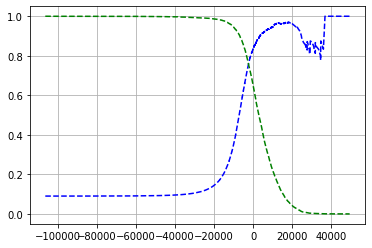

In [46]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_thr(precisions, recalls, thrs):
    plt.plot(thrs, precisions[:-1], "b--", label="precision")
    plt.plot(thrs, recalls[:-1], "g--", label="recall")

plot_precision_recall_vs_thr(precisions, recalls, thrs)
plt.grid()
plt.show()

정밀도 곡석이 왜 더 울퉁불퉁한지 의아할 수도 있음  
임곗값이 높아질 때 TP 샘플이 음성이 되는 경우도 있기 때문  
자세히 말하자면 일반적인 양성 샘플의 결정 점수에 못 미치게 되서

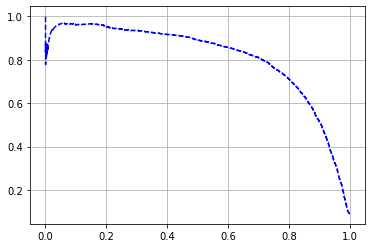

In [48]:
def plot_precision_recall_curve(precisions, recalls, thrs):
    plt.plot(recalls[:-1], precisions[:-1], "b--")
    
plot_precision_recall_curve(precisions, recalls, thrs)
plt.grid()
plt.show()

**재현율에 대한 정밀도 곡선**을 그리는 것도 매우 좋음  
재현율이 0.8근처에서 급격하게 줄어들기 시작함  
> 이 하강점 직전을 트레이드오프로 선택하는 것이 좋음

In [49]:
thr_90_precision = thrs[np.argmax(precisions >= 0.9)]
thr_90_precision

3370.019499143958

만약 정밀도를 90% 달성하는 것이 목표일 경우  
그 때의 가장 작은 임곗값을 찾는 방법 (크면 재현율이 떨어지므로)

In [50]:
y_train_pred_90 = (y_scores >= thr_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

새롭게 결정한 임곗값을 이용하여 기존 결정 점수를 필터링하여 새롭게 양성, 음성을 분류하는 모습

In [51]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [52]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# 4. ROC 곡선
**수신기 조작 특성(ROC: receiver operating characteristic)곡선**도 이진 분류에서 널리 사용됨  
정밀도/재현율 곡선과 매우 비슷하지만 ROC곡선은 **거짓 양성 비율(FPR)** 에 대한 **진짜 양성 비율(TPR) : 재현율** 의 곡선임  
  
FPR은 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 **진짜 음성 비율(TNR)** 을 뺀 값과 같음  
TNR은 **특이도** 라고도 함. 그러므로 ROC곡선은 민감도에 대한 **1-특이도 그래프**임

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, thrs = roc_curve(y_train_5, y_scores)

ROC곡선을 그리기 위해 필요한 정보를 구하는 과정

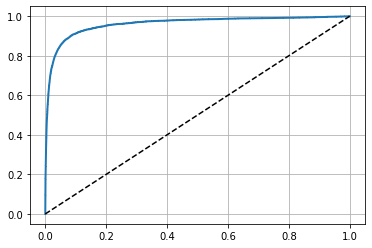

In [55]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")

plot_roc_curve(fpr, tpr)
plt.grid()
plt.show()

ROC커브도 트레이드오프가 있음  
**재현율이 높을수록** 분류기가 만드는 거짓 양성(FPR)이 늘어남  
점선은 완전 랜덤 분류기의 ROC곡선을 뜻함  
좋은 분류기일수록 직선에서 멀어져야 함  
  
> 곡선 아래의 면적 : **AUC(area under the curve)** 이 넓을수록 좋다는 뜻

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

면적이 1에 가까울수록 완벽한 분류기임

ROC곡선과 정밀도/재현율 곡선이 비슷해서 어떤 것을 사용해야 할지 감이 안잡힐 수 있음  
> 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요하다면  
**정밀도/재현율(PR)곡선** 사용
  
> 그렇지 않으면  
**ROC곡선** 사용  

위에 분류기만 봐도 roc곡선만 보면 좋아보이지만 이것은 음성 데이터에 비해 양성 데이터가 크게 적기 때문임  
PR곡선을 보면 성능 개선 여지가 얼마나 되는지 확인할 수 있음

In [59]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3,
                                  method="predict_proba")

랜덤포레스트 분류기를 사용한 예시  
랜덤포레스트는 decision_function메서드가 없음. 대신 **predict_proba**가 있음  
일반적으로 사이킷런 분류기는 이 둘 중 하나를 갖거나 둘 다 갖고 있음  
> predict_proba는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환함
  
>이때 

In [62]:
y_probs_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

첫 번째 열이 **음성일 확률**, 두 번째 열이 **양성일 확률**

In [63]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, thr_forest = roc_curve(y_train_5, y_scores_forest)

roc_curve함수는 레이블과 점수를 기대함  
이때 점수 대신 클래스 확률을 전달할 수도 있음

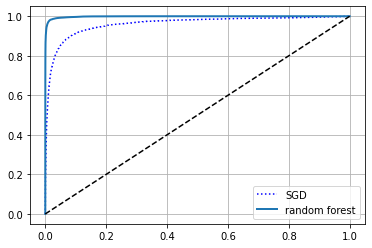

In [65]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.grid()
plt.show()

랜덤포레스트 분류기가 훨씬 좋은 성능을 보임  
마찬가지로 AUC도 훨씬 좋음